#Crowd Energy prediction 

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1. CORE CLEANING & EXTRACTION FUNCTIONS

In [52]:
def clean_ticket_price(price):
    price_str = str(price).strip().lower()

    if 'free' in price_str:
        return 0.0
    
    match = re.search(r'[\d,.]+',price_str)
    if not match:return np.nan
    val = float(match.group().replace(',',''))

    if '£' in price_str:
        val *= 1.27
    elif '€' in price_str:
        val *= 1.09
    
    return max(0.0, val)
    
def extract_dt_strict(val):
    """Standardizes Date/Time and handles strings like 'Late Night' ."""
    val_str = str(val).strip()
    
    try:
        dt = pd.to_datetime(val_str, errors='coerce', format='mixed')
        has_time = any(ind in val_str.lower() for ind in [':','am','pm','morning','afternoon','evening','night'])
        has_date = bool(re.search(r'(\d{4}|\d{1,2}[-/]\d{1,2})',val_str))
        d_out = dt.strftime('%Y-%m-%d') if (pd.notnull(dt) and has_date) else np.nan
        t_out = (dt.strftime('%H:%M:%S') if ':' in val_str else val_str) if has_time else np.nan
        return d_out,t_out
    except: return np.nan,np.nan

# 2. THE TWO-STAGE PIPELINE

In [55]:
def stage_1_clean_for_eda(df, is_train=True):
    df = df.copy()
    # 1. Clean & clip Ticket price(feature)
    df['Ticket_Price']=df['Ticket_Price'].apply(clean_ticket_price)
    df['Ticket_Price']=df['Ticket_Price'].replace(0,np.nan)
    df['Ticket_Price']=df['Ticket_Price'].fillna(df['Ticket_Price'].median())
    df['Ticket_Price']=df['Ticket_Price'].clip(upper=100.0)

    # 2. Extract Date/Time strictly
    dt_res = df['Show_DateTime'].apply(lambda x: pd.Series(extract_dt_strict(x)))
    df['Date_Extracted'],df['Time_Only'] = dt_res[0] ,dt_res[1]

    # 3. Clean & Clip volume (Feature: 1-11)
    if 'Volume_Level' in df.columns:
        df['Volume_Level'] = df['Volume_Level'].replace(0,np.nan).fillna(df['Volume_Level'].median())
        df['Volume_Level'] = df['Volume_Level'].clip(1,11)
    if 'Opener_Rating' in df.columns:
        df['Opener_Rating'] = df['Opener_Rating'].replace(0,np.nan).fillna(df['Opener_Rating'].median())
        df['Opener_Rating'] = df['Opener_Rating'].clip(1,5)

    # 4. Target constraint 0-100 Energy (Train only)
    if is_train and 'Crowd_Energy' in df.columns:
        df=df.dropna(subset=['Crowd_Energy'])
        df=df[(df['Crowd_Energy']>=0)&(df['Crowd_Energy']<=100)]

    return df

def stage_2_finalize(df,is_train=True,train_features=None,additional_drop=None):
    df = df.copy()

    # Feature Engineering
    dt_col = pd.to_datetime(df['Date_Extracted'],errors='coerce')
    df['Day_of_Week'] = dt_col.dt.dayofweek.fillna(-1)
    df['Month'] = dt_col.dt.month.fillna(0).astype(int)
    df['Is_Weekend'] = df['Day_of_Week'].apply(lambda x: 1 if x in [4,5,6] else 0 if x>=0 else -1)

    def get_time_features(time_str):
        if pd.isna(time_str): return -1,"Unknown"
        t_low = str(time_str).lower()
        hour = -1
        match = re.search(r'(\d+):',t_low)
        if match:
            hour = int(match.group(1))
            if 'pm' in t_low and hour<12:
                hour += 12
            elif 'am' in t_low and hour==12:
                hour = 0
        if 5<= hour < 12 or 'morning' in t_low: cat = 'Morning'
        elif 12<= hour < 17 or 'afternoon' in t_low: cat = 'Afternoon'
        elif 17<=hour < 21 or 'evening' in t_low: cat = 'Evening'
        elif hour>=21 or hour < 5 or 'night' in t_low: cat = 'Night'
        else: cat = 'Unknown'
        return hour,cat
    
    time_res = df['Time_Only'].apply(lambda x: pd.Series(get_time_features(x)))
    df['Hour_of_Day'],df['Time_Category'] = time_res[0].astype(float),time_res[1]
    df['Is_Afternoon_Show'] = df['Time_Category'].apply(lambda x: 1 if x=='Afternoon' else 0 if x!='Unknown' else -1)
    df['Is_Night_Show'] = df['Time_Category'].apply(lambda x: 1 if x=='Night' else 0 if x!='Unknown' else -1)
    
    # Venue specific features
    df['Alpha_Volume'] = np.where(df['Venue_ID']=='V_Alpha',df['Volume_Level'],0)
    df['Delta_Volume'] = np.where(df['Venue_ID']=='V_Delta',df['Volume_Level'],0)
    df['Alpha-Opener'] = np.where(df['Venue_ID']=='V_Alpha',df['Opener_Rating'],0)
    df['Gamma_Opener'] = np.where(df['Venue_ID']=='V_Gamma',df['Opener_Rating'],0)
    df['Beta_Afternoon_Show'] = np.where(df['Venue_ID']=='V_Beta',df['Is_Afternoon_Show'],0)
    df['Gamma_Afternoon_Show'] = np.where(df['Venue_ID']=='V_Gamma',df['Is_Afternoon_Show'],0)
    df['Beta_Outfit'] = np.where(df['Venue_ID']=='V_Beta',df['Band_Outfit'],'Other')
    df['Beta_weather'] = np.where(df['Venue_ID']=='V_Beta',df['Weather'],'Other')
    df['Delta_weather'] = np.where(df['Venue_ID']=='V_Delta',df['Weather'],'Other')
    df['Beta_is_weekend'] = np.where((df['Venue_ID']=='V_Beta') & (df['Is_Weekend']==1),1,0)
    df['Beta_Moon_Phase'] = np.where(df['Venue_ID']=='V_Beta',df['Moon_Phase'],'Other')
    df['Value_For_Money'] = df['Volume_Level']/(df['Ticket_Price']+1)
    df['Log_Value_Score'] = np.log1p(df['Volume_Level'])/np.log1p(df['Ticket_Price'])
    df['Month_Sin'] = np.sin(2*np.pi * df['Month']/12)
    df['Month_Cos'] = np.cos(2*np.pi * df['Month']/12)

    # columns to drop(leakage,metadata,red herrings)
    to_drop = ['Merch_Sales_Post_Show','Crowd_Size','Gig_ID','Show_DateTime','Date_Extracted','Time_Only']
    if additional_drop: to_drop.extend(additional_drop)

    X=df.drop(columns=[c for c in to_drop if c in df.columns],errors='ignore')
    columns_to_dummy = [col for col in ['Venue_ID','Weather','Moon_Phase','Band_Outfit','Time_Category','Beta_Outfit','Beta_weather','Delta_weather','Beta_Moon_Phase'] if col in X.columns]
    X=pd.get_dummies(X, columns=columns_to_dummy)


    if is_train:
        y = X.pop('Crowd_Energy')
        return X,y
    else:
        if train_features is not None:
            X=X.reindex(columns=train_features,fill_value=0)
            return X

# 3. EXECUTION WORKFLOW

In [54]:
raw_train = pd.read_csv('tour_logs_train.csv')
train_eda = stage_1_clean_for_eda(raw_train,is_train=True)
train_df = train_eda.copy()

AttributeError: 'Series' object has no attribute 'raplace'

# EDA

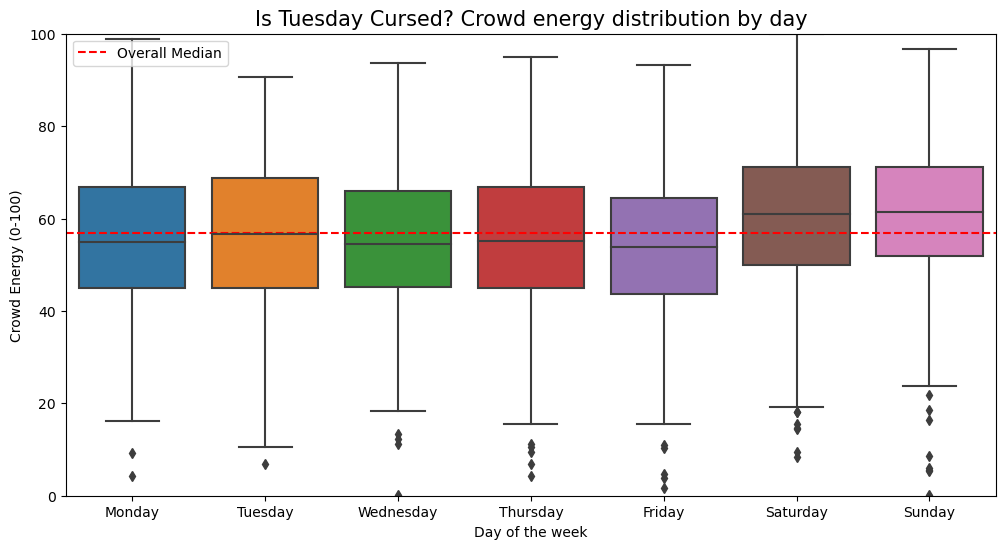

In [ ]:
# Assuming train_eda has Date_Extracted, get Day_of_Week
train_eda['Day_of_Week'] = pd.to_datetime(train_eda['Date_Extracted'], errors='coerce').dt.dayofweek.fillna(-1)

df = train_eda.copy()
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['Day_Name'] = df['Day_of_Week'].map(day_names)
df_clean = df[df['Crowd_Energy'] > 0].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='Day_Name', y='Crowd_Energy', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.axhline(df_clean['Crowd_Energy'].median(), color='r', linestyle='--', label='Overall Median')
plt.title("Is Tuesday Cursed? Crowd energy distribution by day", fontsize=15)
plt.ylabel("Crowd Energy (0-100)")
plt.xlabel("Day of the week")
plt.ylim(0, 100)
plt.legend()
plt.show()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


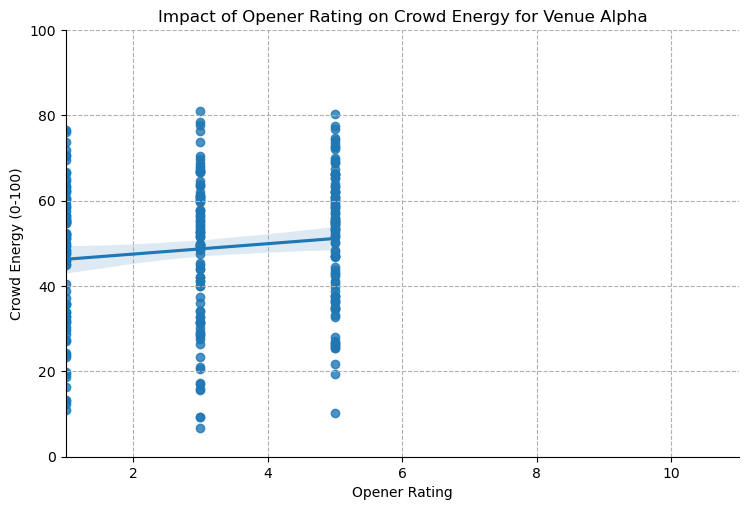

In [ ]:
# Best plot: Scatter plot with regression line (lmplot) to visualize the relationship between Opener Rating and crowd energy
venue_a_df = train_eda[train_eda['Venue_ID'] == 'V_Alpha']
df_plot = venue_a_df[(venue_a_df['Opener_Rating']) & (venue_a_df['Crowd_Energy'].between(0, 100))]
sns.lmplot(data=df_plot, x='Opener_Rating', y='Crowd_Energy', aspect=1.5)
plt.title('Impact of Opener Rating on Crowd Energy for Venue Alpha')
plt.xlabel('Opener Rating')
plt.ylabel('Crowd Energy (0-100)')
plt.grid(True, linestyle='--')
plt.xlim(1, 11)
plt.ylim(0, 100)
plt.show()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


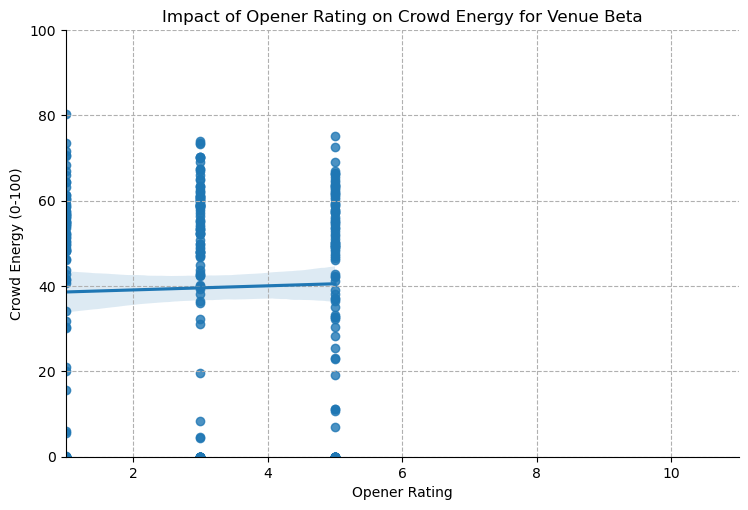

In [ ]:
# Best plot: Scatter plot with regression line (lmplot) to visualize the relationship between Opener Rating and crowd energy
venue_b_df = train_eda[train_eda['Venue_ID'] == 'V_Beta']
df_plot = venue_b_df[(venue_b_df['Opener_Rating']) & (venue_b_df['Crowd_Energy'].between(0, 100))]
sns.lmplot(data=df_plot, x='Opener_Rating', y='Crowd_Energy', aspect=1.5)
plt.title('Impact of Opener Rating on Crowd Energy for Venue Beta')
plt.xlabel('Opener Rating')
plt.ylabel('Crowd Energy (0-100)')
plt.grid(True, linestyle='--')
plt.xlim(1, 11)
plt.ylim(0, 100)
plt.show()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


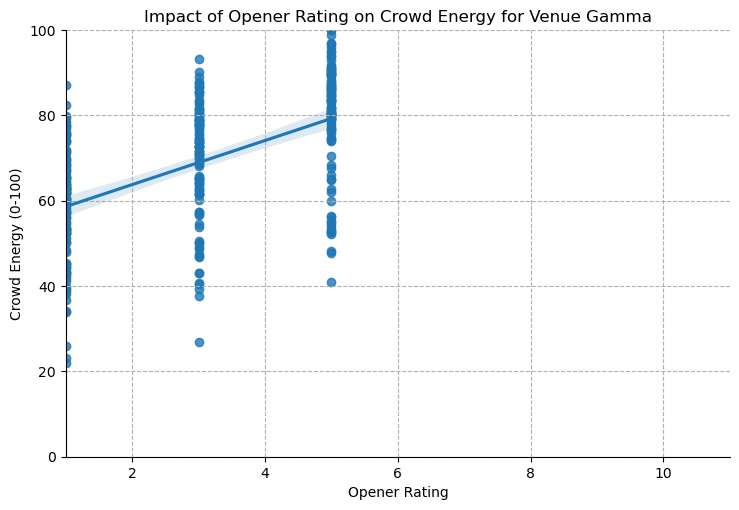

In [ ]:
# Best plot: Scatter plot with regression line (lmplot) to visualize the relationship between Opener Rating and crowd energy
venue_c_df = train_eda[train_eda['Venue_ID'] == 'V_Gamma']
df_plot = venue_c_df[(venue_c_df['Opener_Rating']) & (venue_c_df['Crowd_Energy'].between(0, 100))]
sns.lmplot(data=df_plot, x='Opener_Rating', y='Crowd_Energy', aspect=1.5)
plt.title('Impact of Opener Rating on Crowd Energy for Venue Gamma')
plt.xlabel('Opener Rating')
plt.ylabel('Crowd Energy (0-100)')
plt.grid(True, linestyle='--')
plt.xlim(1, 11)
plt.ylim(0, 100)
plt.show()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


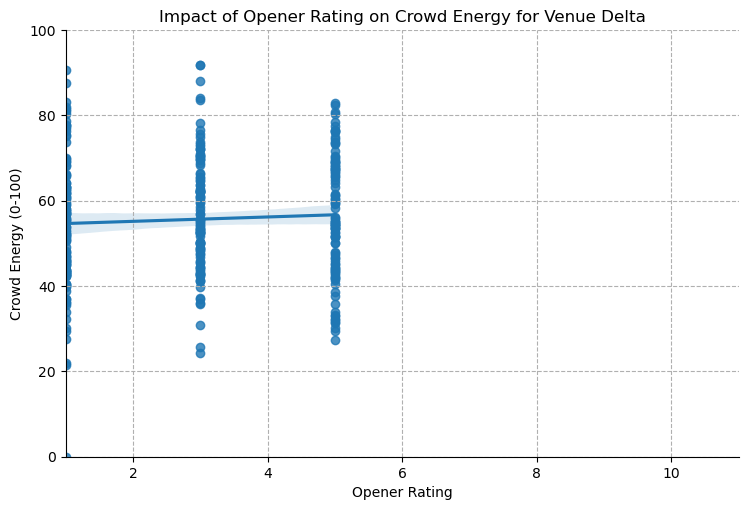

In [ ]:
# Best plot: Scatter plot with regression line (lmplot) to visualize the relationship between volume level and crowd energy
venue_d_df = train_eda[train_eda['Venue_ID'] == 'V_Delta']
df_plot = venue_d_df[(venue_d_df['Opener_Rating']) & (venue_d_df['Crowd_Energy'].between(0, 100))]
sns.lmplot(data=df_plot, x='Opener_Rating', y='Crowd_Energy', aspect=1.5)
plt.title('Impact of Opener Rating on Crowd Energy for Venue Delta')
plt.xlabel('Opener Rating')
plt.ylabel('Crowd Energy (0-100)')
plt.grid(True, linestyle='--')
plt.xlim(1, 11)
plt.ylim(0, 100)
plt.show()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


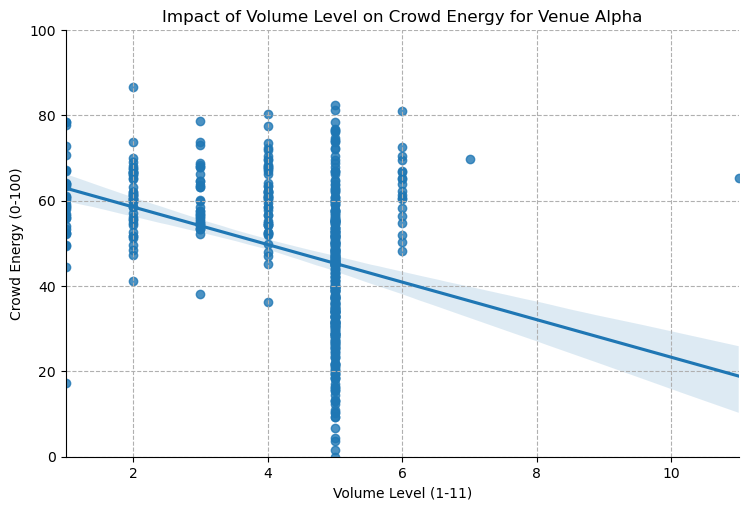

In [ ]:
# Best plot: Scatter plot with regression line (lmplot) to visualize the relationship between volume level and crowd energy
venue_a_df = train_eda[train_eda['Venue_ID'] == 'V_Alpha']
df_plot = venue_a_df[(venue_a_df['Volume_Level'].between(1, 11)) & (venue_a_df['Crowd_Energy'].between(0, 100))]
sns.lmplot(data=df_plot, x='Volume_Level', y='Crowd_Energy', aspect=1.5)
plt.title('Impact of Volume Level on Crowd Energy for Venue Alpha')
plt.xlabel('Volume Level (1-11)')
plt.ylabel('Crowd Energy (0-100)')
plt.grid(True, linestyle='--')
plt.xlim(1, 11)
plt.ylim(0, 100)
plt.show()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


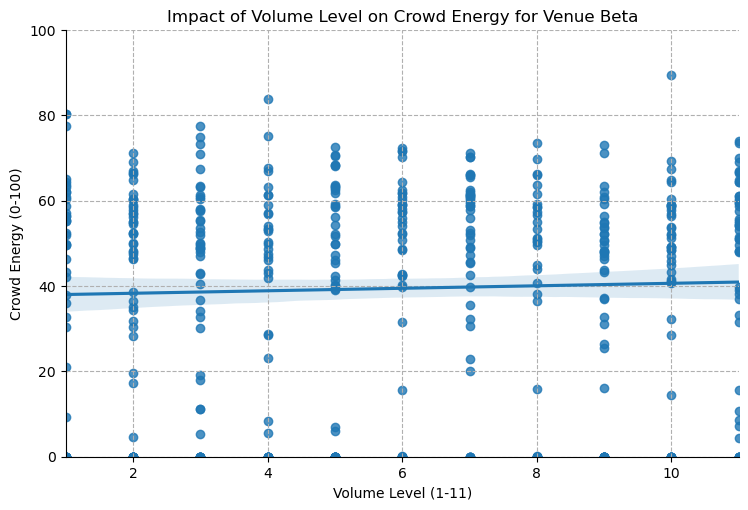

In [ ]:
# Scatter plot with regression line for Venue Beta
venue_b_df = train_eda[train_eda['Venue_ID'] == 'V_Beta']
df_plot = venue_b_df[(venue_b_df['Volume_Level'].between(1, 11)) & (venue_b_df['Crowd_Energy'].between(0, 100))]
sns.lmplot(data=df_plot, x='Volume_Level', y='Crowd_Energy', aspect=1.5)
plt.title('Impact of Volume Level on Crowd Energy for Venue Beta')
plt.xlabel('Volume Level (1-11)')
plt.ylabel('Crowd Energy (0-100)')
plt.grid(True, linestyle='--')
plt.xlim(1, 11)
plt.ylim(0, 100)
plt.show()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


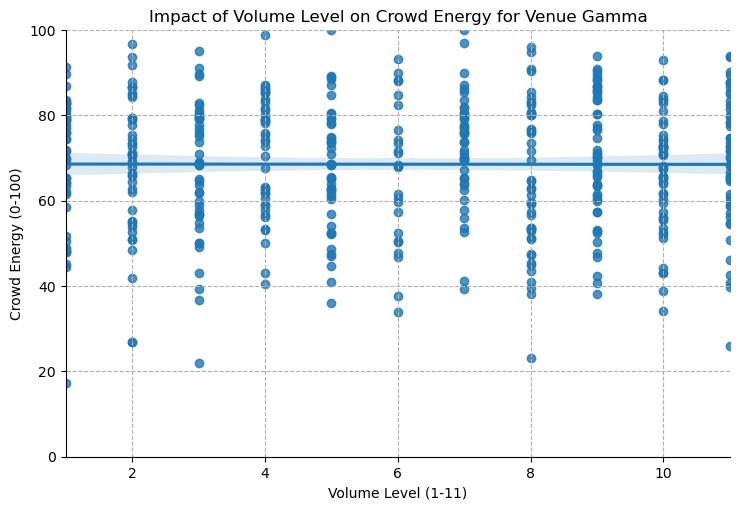

In [ ]:
# Scatter plot with regression line for Venue Gamma
venue_c_df = train_eda[train_eda['Venue_ID'] == 'V_Gamma']
df_plot = venue_c_df[(venue_c_df['Volume_Level'].between(1, 11)) & (venue_c_df['Crowd_Energy'].between(0, 100))]
sns.lmplot(data=df_plot, x='Volume_Level', y='Crowd_Energy', aspect=1.5)
plt.title('Impact of Volume Level on Crowd Energy for Venue Gamma')
plt.xlabel('Volume Level (1-11)')
plt.ylabel('Crowd Energy (0-100)')
plt.grid(True, linestyle='--')
plt.xlim(1, 11)
plt.ylim(0, 100)
plt.show()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


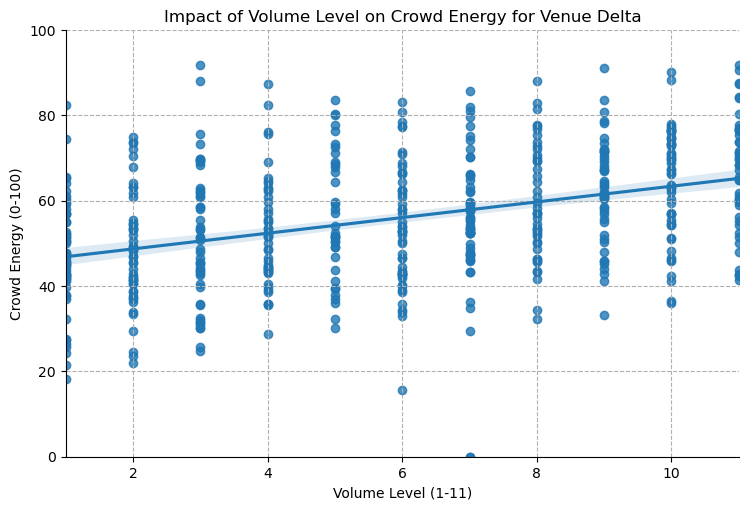

In [ ]:
# Scatter plot with regression line for Venue Delta
venue_d_df = train_eda[train_eda['Venue_ID'] == 'V_Delta']
df_plot = venue_d_df[(venue_d_df['Volume_Level'].between(1, 11)) & (venue_d_df['Crowd_Energy'].between(0, 100))]
sns.lmplot(data=df_plot, x='Volume_Level', y='Crowd_Energy', aspect=1.5)
plt.title('Impact of Volume Level on Crowd Energy for Venue Delta')
plt.xlabel('Volume Level (1-11)')
plt.ylabel('Crowd Energy (0-100)')
plt.grid(True, linestyle='--')
plt.xlim(1, 11)
plt.ylim(0, 100)
plt.show()

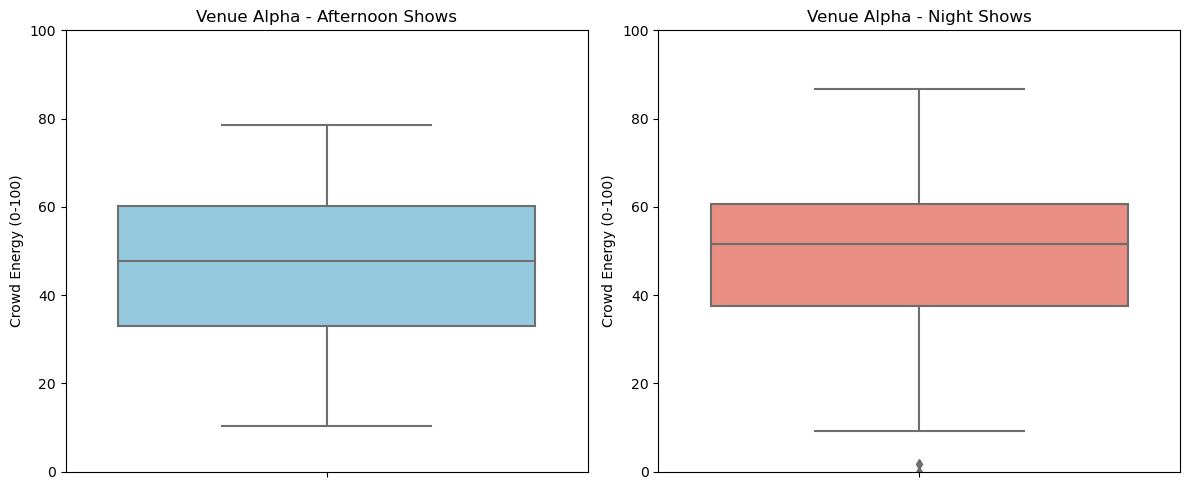

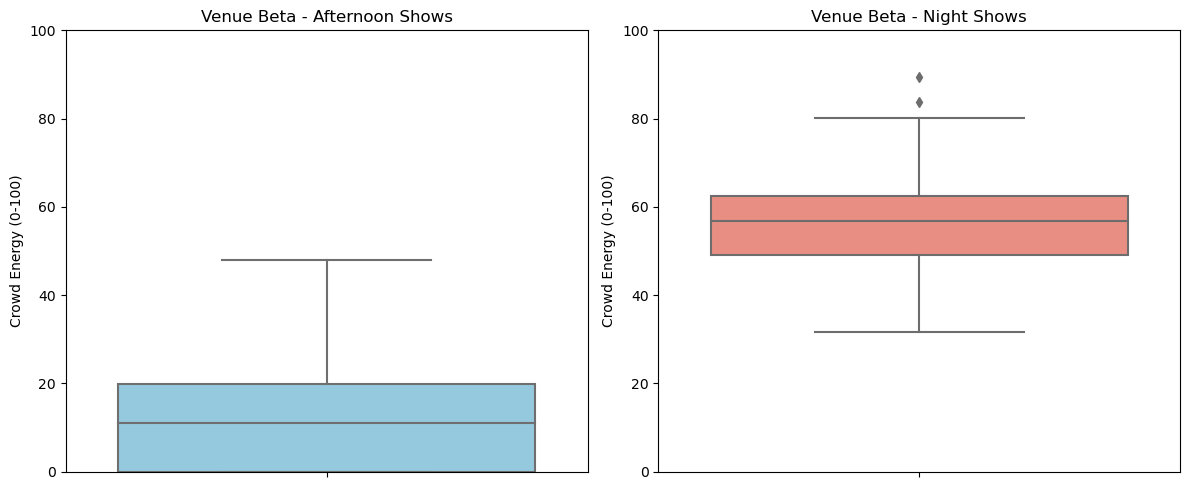

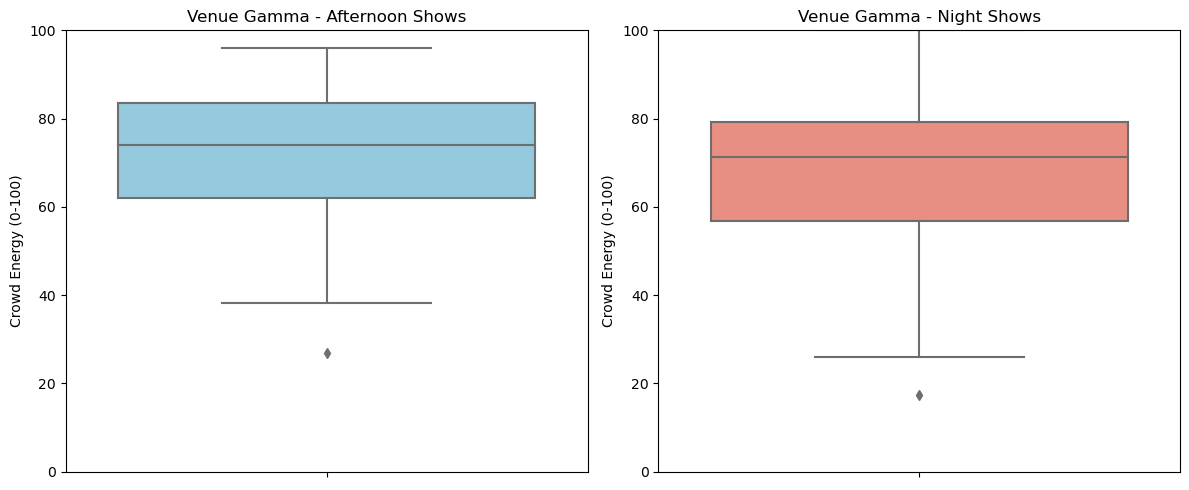

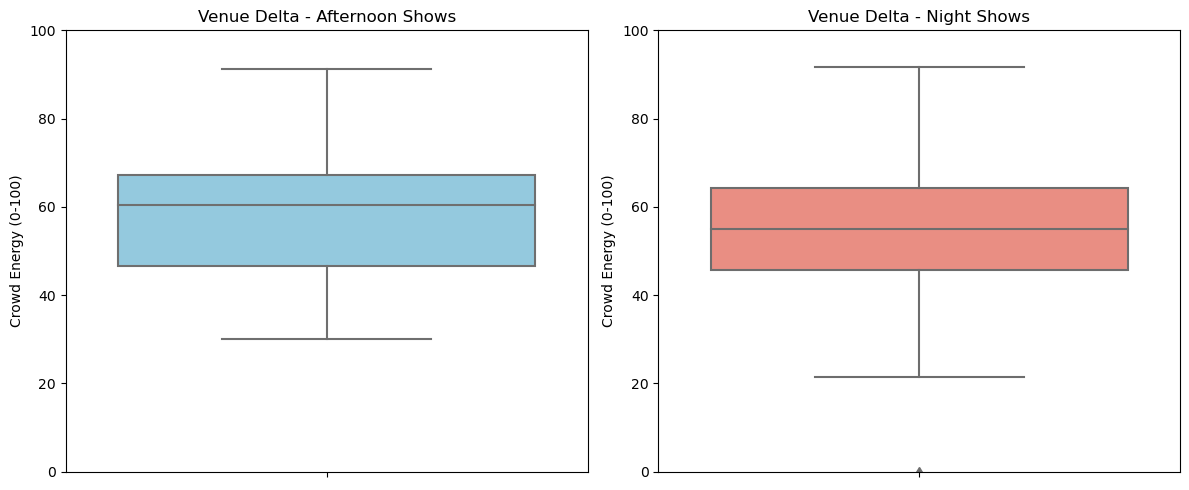

In [ ]:
# Add Time_Category to train_eda
def get_time_category(time_str):
    if pd.isna(time_str): return "Unknown"
    t_low = str(time_str).lower()
    hour = -1
    match = re.search(r'(\d+):', t_low)
    if match:
        hour = int(match.group(1))
        if 'pm' in t_low and hour < 12:
            hour += 12
        elif 'am' in t_low and hour == 12:
            hour = 0
    if 5 <= hour < 12 or 'morning' in t_low: return 'Morning'
    elif 12 <= hour < 17 or 'afternoon' in t_low: return 'Afternoon'
    elif 17 <= hour < 21 or 'evening' in t_low: return 'Evening'
    elif hour >= 21 or hour < 5 or 'night' in t_low: return 'Night'
    else: return 'Unknown'

train_eda['Time_Category'] = train_eda['Time_Only'].apply(get_time_category)

# Function to plot comparison for a venue
def plot_afternoon_night_comparison(venue_id, venue_name):
    venue_df = train_eda[train_eda['Venue_ID'] == venue_id]
    df_afternoon = venue_df[venue_df['Time_Category'] == 'Afternoon']
    df_night = venue_df[venue_df['Time_Category'] == 'Night']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Afternoon
    if not df_afternoon.empty:
        sns.boxplot(data=df_afternoon, y='Crowd_Energy', ax=ax1, color='skyblue')
        ax1.set_title(f'{venue_name} - Afternoon Shows')
        ax1.set_ylabel('Crowd Energy (0-100)')
        ax1.set_ylim(0, 100)
    else:
        ax1.text(0.5, 0.5, 'No Afternoon Data', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title(f'{venue_name} - Afternoon Shows')
    
    # Night
    if not df_night.empty:
        sns.boxplot(data=df_night, y='Crowd_Energy', ax=ax2, color='salmon')
        ax2.set_title(f'{venue_name} - Night Shows')
        ax2.set_ylabel('Crowd Energy (0-100)')
        ax2.set_ylim(0, 100)
    else:
        ax2.text(0.5, 0.5, 'No Night Data', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title(f'{venue_name} - Night Shows')
    
    plt.tight_layout()
    plt.show()

# Plot for each venue
plot_afternoon_night_comparison('V_Alpha', 'Venue Alpha')
plot_afternoon_night_comparison('V_Beta', 'Venue Beta')
plot_afternoon_night_comparison('V_Gamma', 'Venue Gamma')
plot_afternoon_night_comparison('V_Delta', 'Venue Delta')

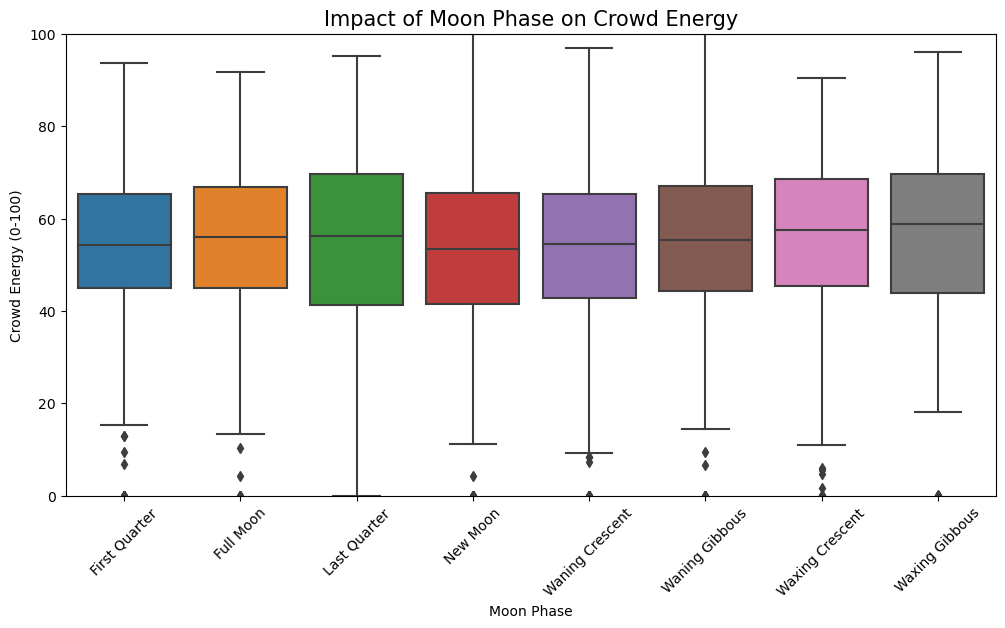

In [ ]:
# Best plot: Box plot to visualize crowd energy distribution by moon phase
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_eda, x='Moon_Phase', y='Crowd_Energy', order=sorted(train_eda['Moon_Phase'].unique()))
plt.title('Impact of Moon Phase on Crowd Energy', fontsize=15)
plt.ylabel('Crowd Energy (0-100)')
plt.xlabel('Moon Phase')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.show()

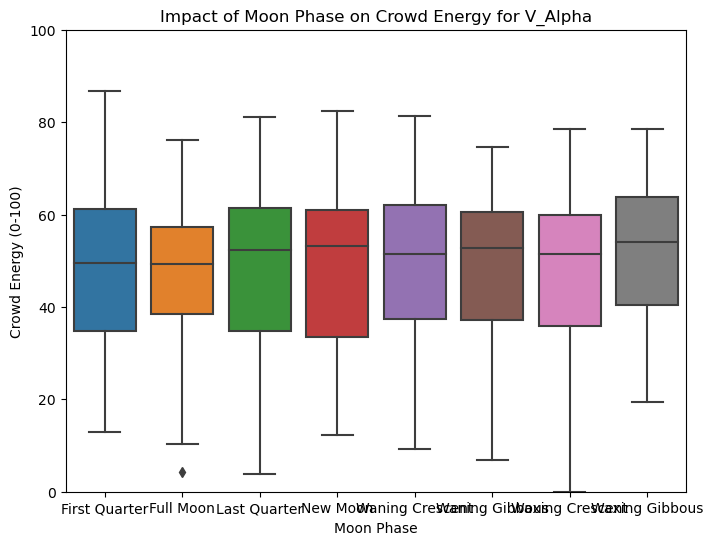

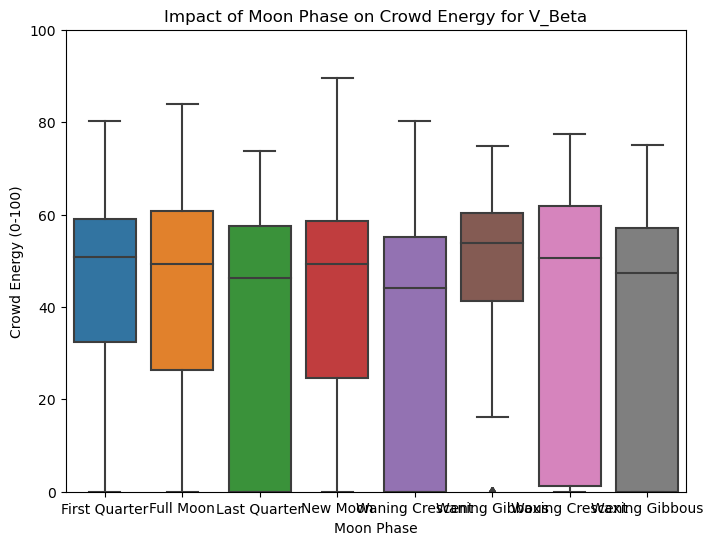

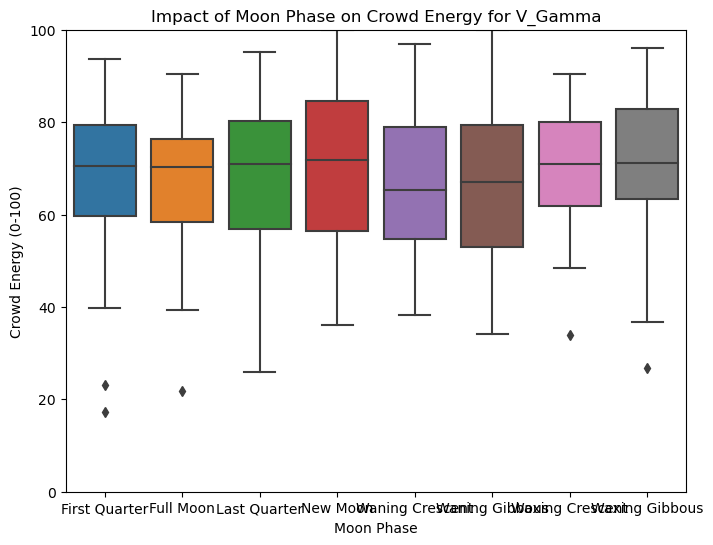

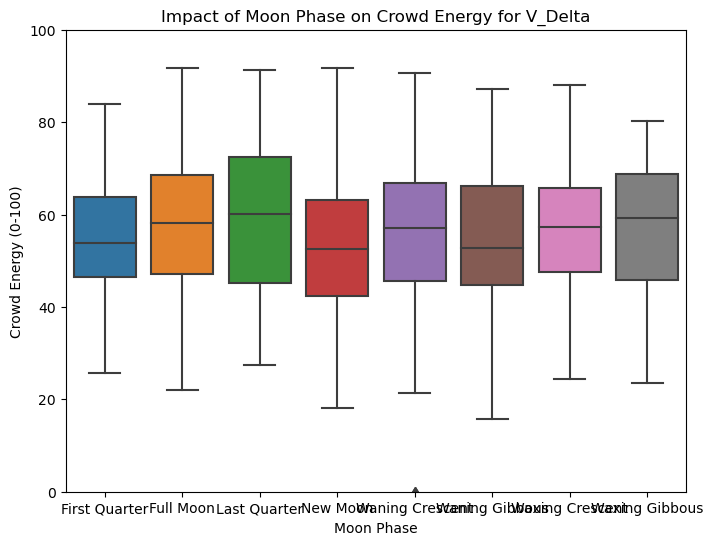

In [ ]:
# Check moon phase impact on crowd energy venue-wise
for venue in ['V_Alpha', 'V_Beta', 'V_Gamma', 'V_Delta']:
    venue_df = train_eda[train_eda['Venue_ID'] == venue]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=venue_df, x='Moon_Phase', y='Crowd_Energy', order=sorted(venue_df['Moon_Phase'].unique()))
    plt.title(f'Impact of Moon Phase on Crowd Energy for {venue}')
    plt.ylabel('Crowd Energy (0-100)')
    plt.xlabel('Moon Phase')
    plt.ylim(0, 100)
    plt.show()

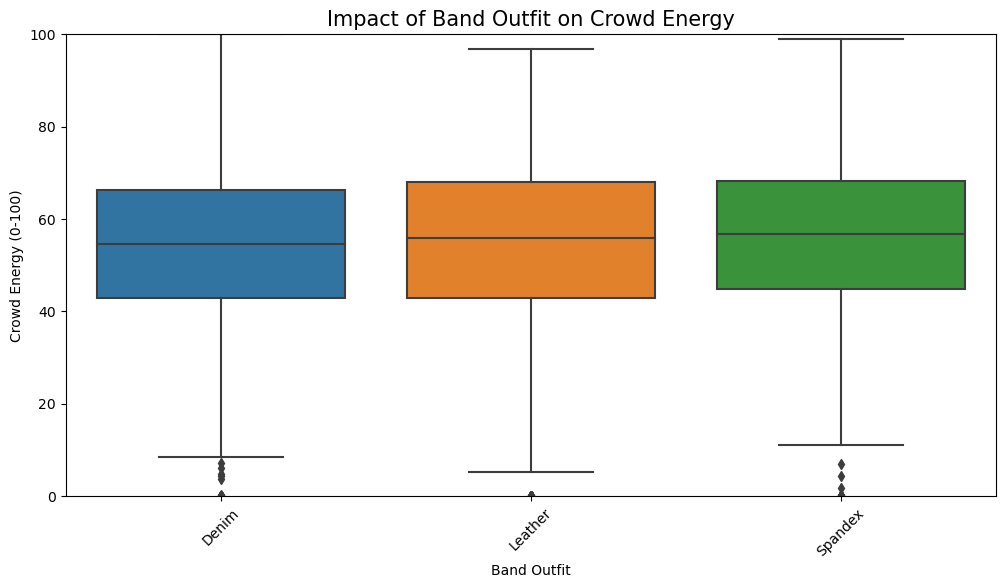

In [ ]:
# Best plot: Box plot to visualize crowd energy distribution by band outfit
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_eda, x='Band_Outfit', y='Crowd_Energy', order=sorted(train_eda['Band_Outfit'].unique()))
plt.title('Impact of Band Outfit on Crowd Energy', fontsize=15)
plt.ylabel('Crowd Energy (0-100)')
plt.xlabel('Band Outfit')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.show()

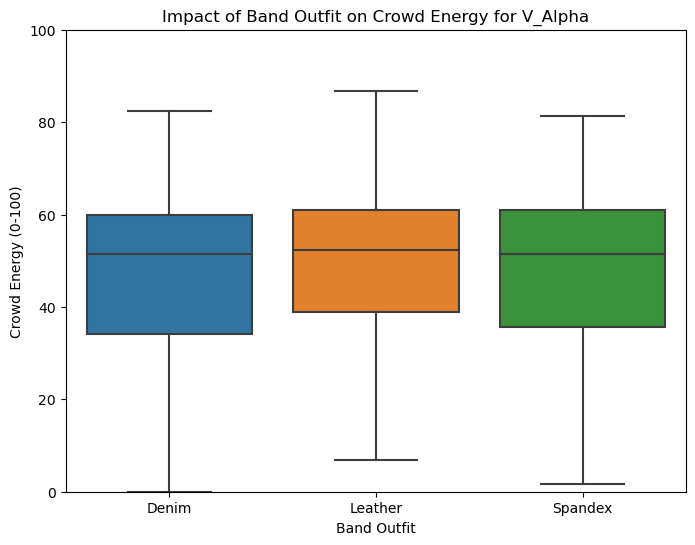

V_Alpha - Denim: Median: 51.36, Count: 184
V_Alpha - Leather: Median: 52.26, Count: 175
V_Alpha - Spandex: Median: 51.50, Count: 128



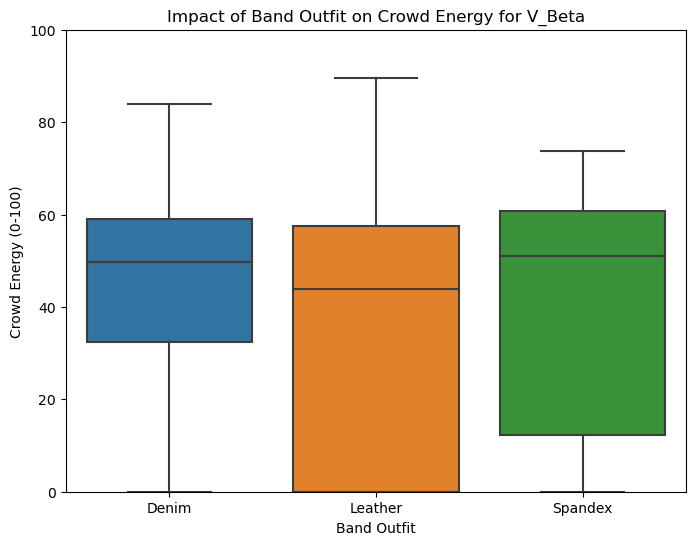

V_Beta - Denim: Median: 49.63, Count: 180
V_Beta - Leather: Median: 43.80, Count: 177
V_Beta - Spandex: Median: 51.02, Count: 126



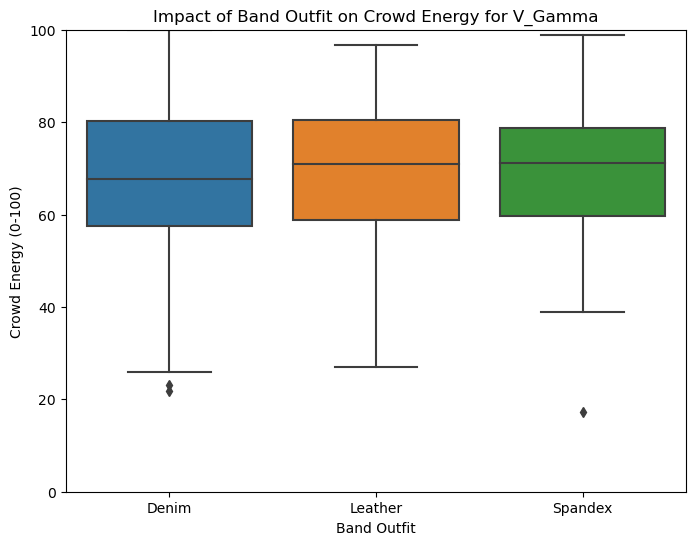

V_Gamma - Denim: Median: 67.68, Count: 174
V_Gamma - Leather: Median: 71.01, Count: 195
V_Gamma - Spandex: Median: 71.18, Count: 114



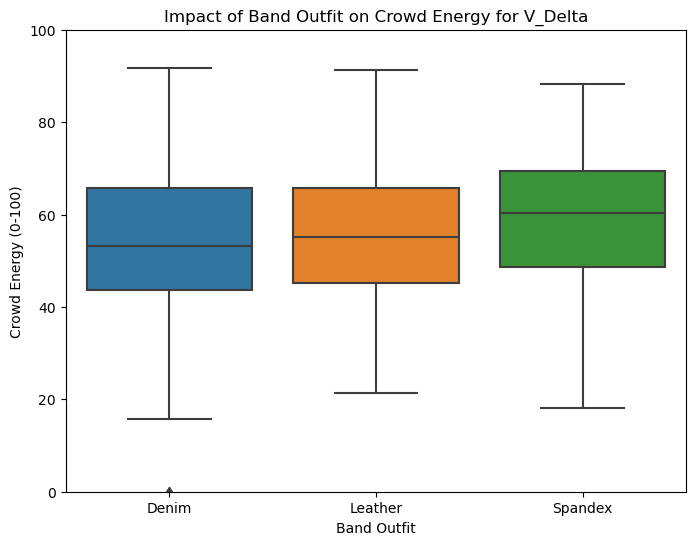

V_Delta - Denim: Median: 53.18, Count: 200
V_Delta - Leather: Median: 55.03, Count: 226
V_Delta - Spandex: Median: 60.30, Count: 113



In [ ]:
# Check band outfit impact on crowd energy venue-wise
for venue in ['V_Alpha', 'V_Beta', 'V_Gamma', 'V_Delta']:
    venue_df = train_eda[train_eda['Venue_ID'] == venue]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=venue_df, x='Band_Outfit', y='Crowd_Energy', order=sorted(venue_df['Band_Outfit'].unique()))
    plt.title(f'Impact of Band Outfit on Crowd Energy for {venue}')
    plt.ylabel('Crowd Energy (0-100)')
    plt.xlabel('Band Outfit')
    plt.ylim(0, 100)
    plt.show()
    
    # Print medians
    for outfit in sorted(venue_df['Band_Outfit'].unique()):
        outfit_df = venue_df[venue_df['Band_Outfit'] == outfit]
        median_energy = outfit_df['Crowd_Energy'].median()
        count = len(outfit_df)
        print(f"{venue} - {outfit}: Median: {median_energy:.2f}, Count: {count}")
    print()

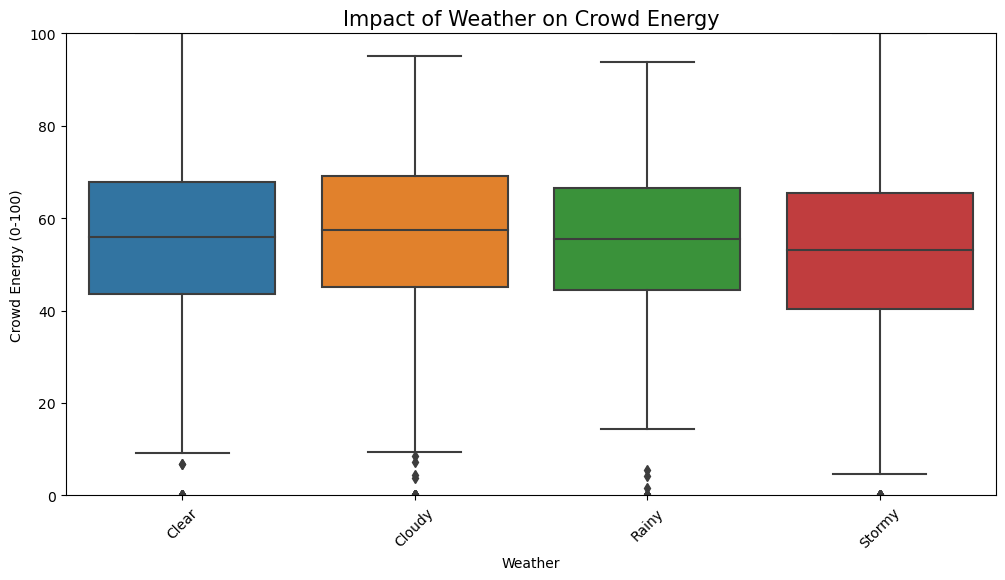

In [ ]:
# Best plot: Box plot to visualize crowd energy distribution by weather
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_eda, x='Weather', y='Crowd_Energy', order=sorted(train_eda['Weather'].unique()))
plt.title('Impact of Weather on Crowd Energy', fontsize=15)
plt.ylabel('Crowd Energy (0-100)')
plt.xlabel('Weather')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.show()

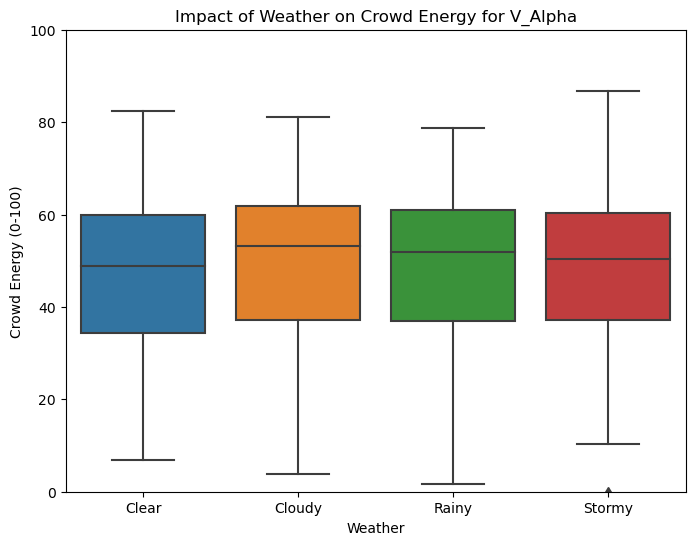

V_Alpha - Clear: Median: 48.78, Count: 123
V_Alpha - Cloudy: Median: 53.11, Count: 119
V_Alpha - Rainy: Median: 51.92, Count: 120
V_Alpha - Stormy: Median: 50.28, Count: 125



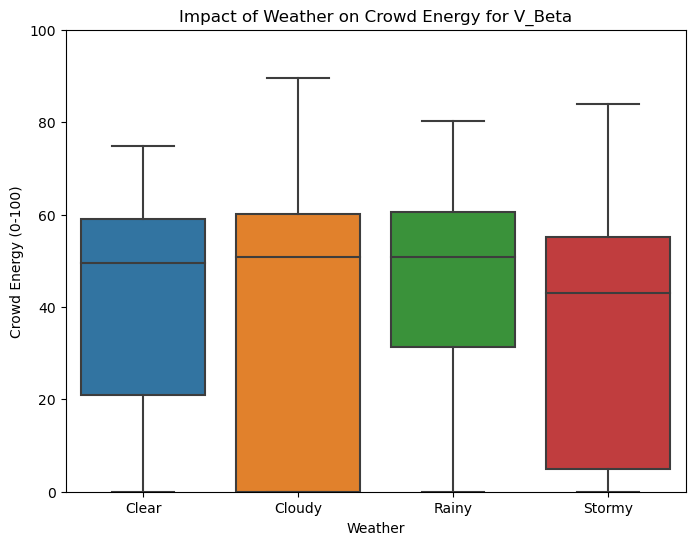

V_Beta - Clear: Median: 49.58, Count: 109
V_Beta - Cloudy: Median: 50.70, Count: 119
V_Beta - Rainy: Median: 50.75, Count: 124
V_Beta - Stormy: Median: 42.93, Count: 131



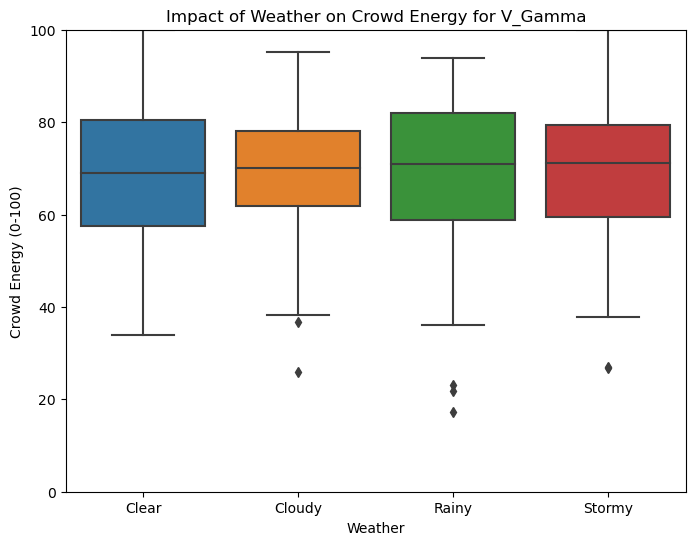

V_Gamma - Clear: Median: 68.99, Count: 127
V_Gamma - Cloudy: Median: 70.11, Count: 109
V_Gamma - Rainy: Median: 71.01, Count: 119
V_Gamma - Stormy: Median: 71.25, Count: 128



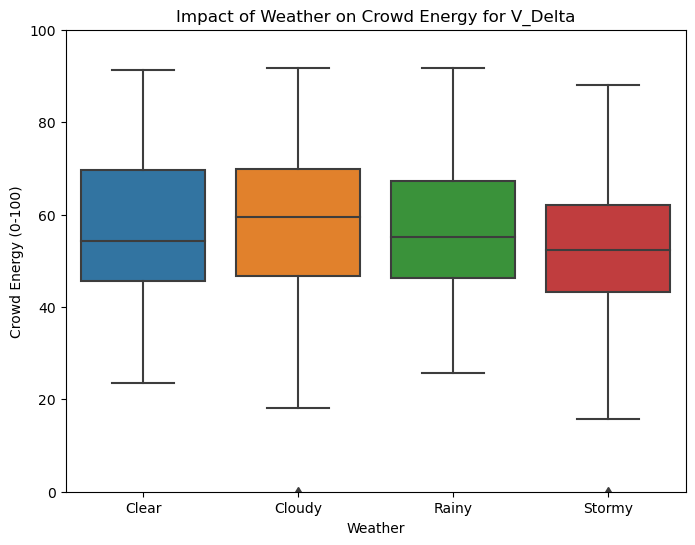

V_Delta - Clear: Median: 54.22, Count: 125
V_Delta - Cloudy: Median: 59.40, Count: 132
V_Delta - Rainy: Median: 55.14, Count: 142
V_Delta - Stormy: Median: 52.42, Count: 140



In [ ]:
# Check weather impact on crowd energy venue-wise
for venue in ['V_Alpha', 'V_Beta', 'V_Gamma', 'V_Delta']:
    venue_df = train_eda[train_eda['Venue_ID'] == venue]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=venue_df, x='Weather', y='Crowd_Energy', order=sorted(venue_df['Weather'].unique()))
    plt.title(f'Impact of Weather on Crowd Energy for {venue}')
    plt.ylabel('Crowd Energy (0-100)')
    plt.xlabel('Weather')
    plt.ylim(0, 100)
    plt.show()
    
    # Print medians
    for weather in sorted(venue_df['Weather'].unique()):
        weather_df = venue_df[venue_df['Weather'] == weather]
        median_energy = weather_df['Crowd_Energy'].median()
        count = len(weather_df)
        print(f"{venue} - {weather}: Median: {median_energy:.2f}, Count: {count}")
    print()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


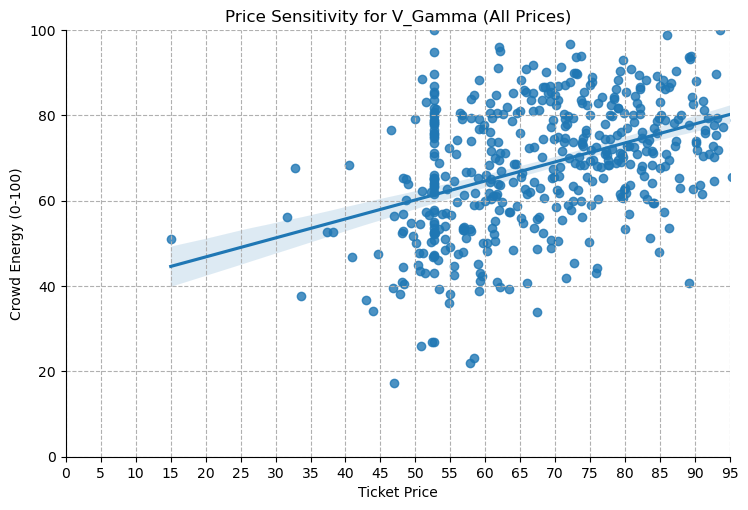

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


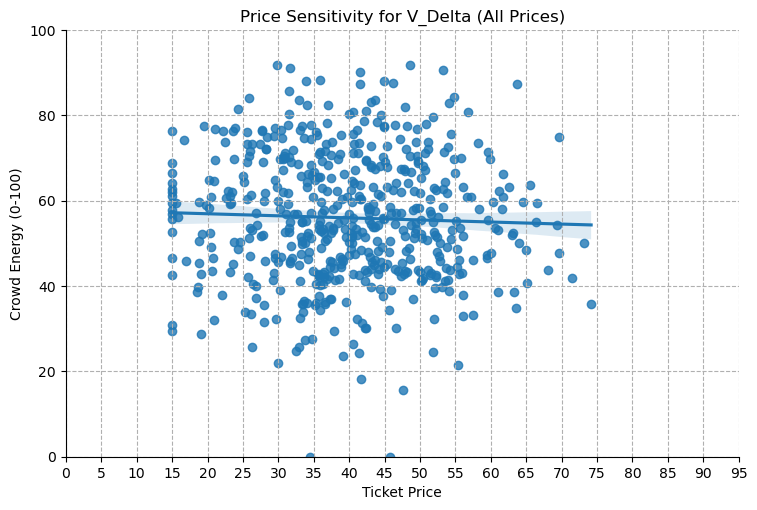

In [ ]:
# Check price sensitivity for Venue Gamma and Delta with all prices
for venue in ['V_Gamma', 'V_Delta']:
    venue_df = train_eda[train_eda['Venue_ID'] == venue]
    sns.lmplot(data=venue_df, x='Ticket_Price', y='Crowd_Energy', aspect=1.5)
    plt.title(f'Price Sensitivity for {venue} (All Prices)')
    plt.xlabel('Ticket Price')
    plt.ylabel('Crowd Energy (0-100)')
    plt.xlim(30, 90)
    plt.xticks(range(0, 100, 5))
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--')
    plt.show()

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


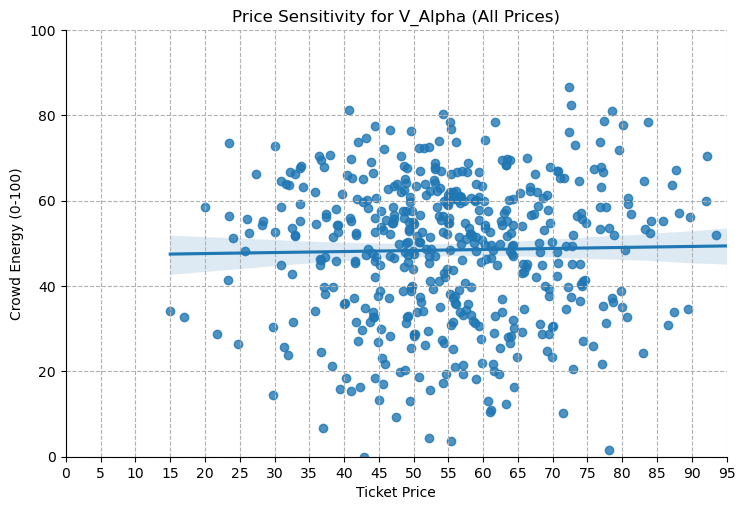

/Users/imlohith/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


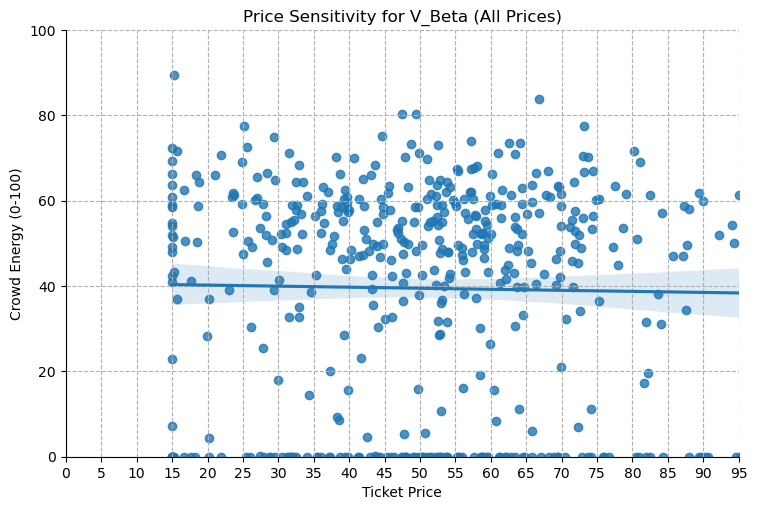

In [ ]:
# Check price sensitivity for Venue Alpha and Beta with all prices
for venue in ['V_Alpha', 'V_Beta']:
    venue_df = train_eda[train_eda['Venue_ID'] == venue]
    sns.lmplot(data=venue_df, x='Ticket_Price', y='Crowd_Energy', aspect=1.5)
    plt.title(f'Price Sensitivity for {venue} (All Prices)')
    plt.xlabel('Ticket Price')
    plt.ylabel('Crowd Energy (0-100)')
    plt.xlim(30, 90)
    plt.xticks(range(0, 100, 5))
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--')
    plt.show()

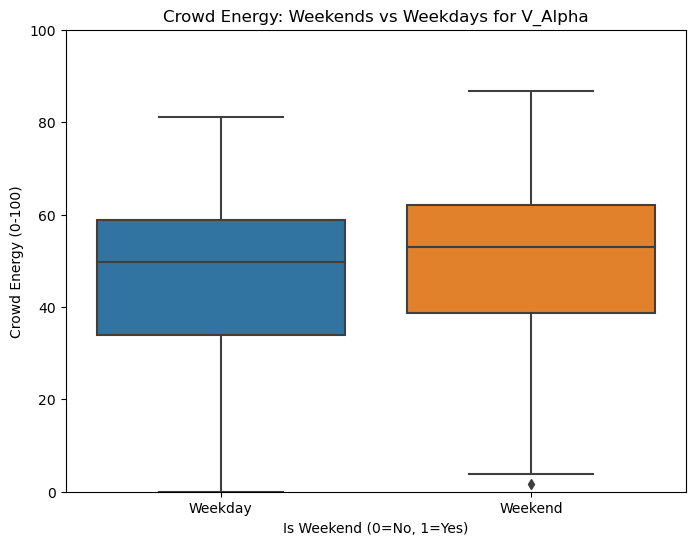

V_Alpha - Weekday Median: 49.64, Weekend Median: 52.95



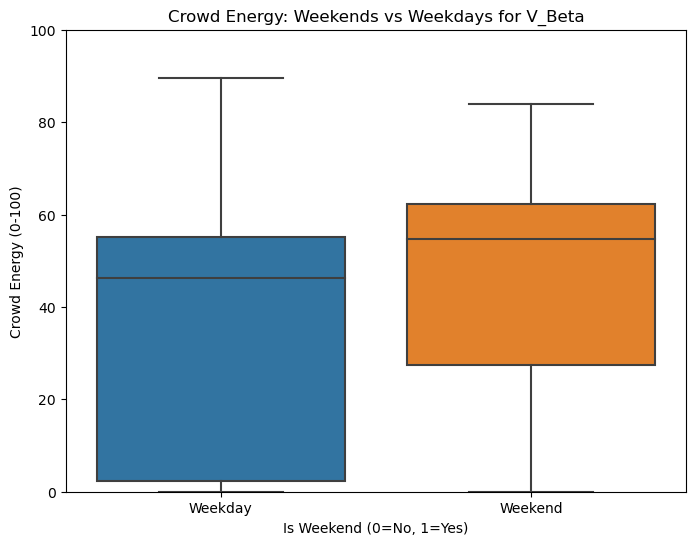

V_Beta - Weekday Median: 46.36, Weekend Median: 54.69



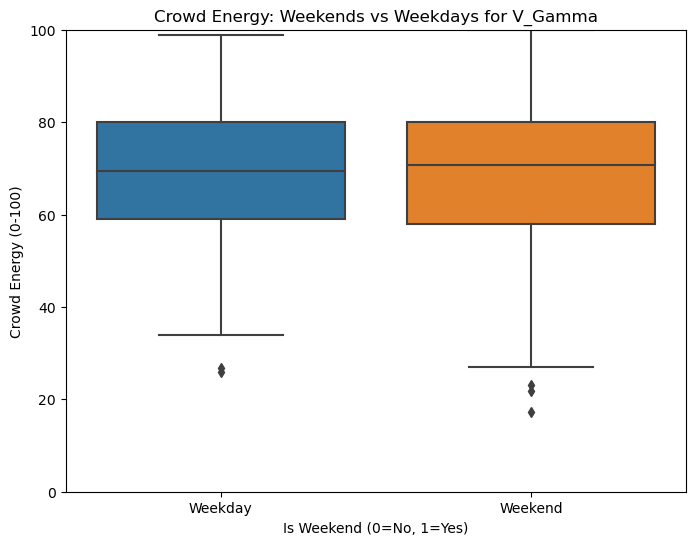

V_Gamma - Weekday Median: 69.41, Weekend Median: 70.79



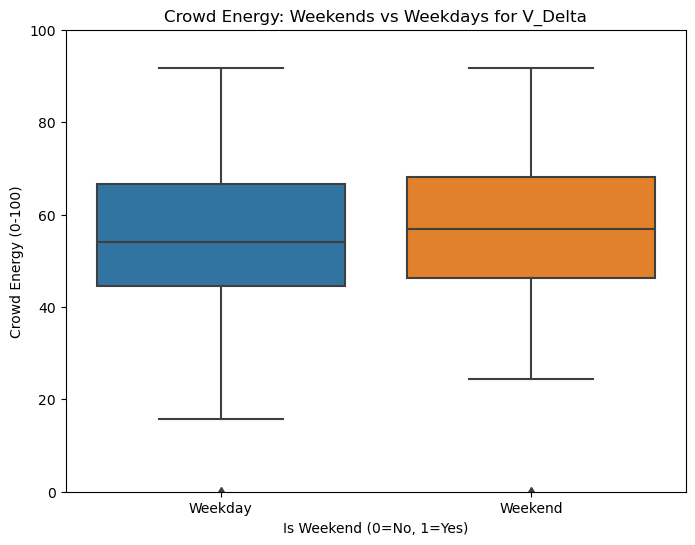

V_Delta - Weekday Median: 54.08, Weekend Median: 56.94



In [ ]:
# Check if weekends are better at all venues or only at some
train_eda['Is_Weekend'] = train_eda['Day_of_Week'].apply(lambda x: 1 if x in [4,5, 6] else 0)

for venue in ['V_Alpha', 'V_Beta', 'V_Gamma', 'V_Delta']:
    venue_df = train_eda[train_eda['Venue_ID'] == venue]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=venue_df, x='Is_Weekend', y='Crowd_Energy')
    plt.title(f'Crowd Energy: Weekends vs Weekdays for {venue}')
    plt.xlabel('Is Weekend (0=No, 1=Yes)')
    plt.ylabel('Crowd Energy (0-100)')
    plt.ylim(0, 100)
    plt.xticks([0, 1], ['Weekday', 'Weekend'])
    plt.show()
    
    # Print medians
    weekday_median = venue_df[venue_df['Is_Weekend'] == 0]['Crowd_Energy'].median()
    weekend_median = venue_df[venue_df['Is_Weekend'] == 1]['Crowd_Energy'].median()
    print(f"{venue} - Weekday Median: {weekday_median:.2f}, Weekend Median: {weekend_median:.2f}")
    print()

In [56]:
# Drop Red herrings and Encode
red_herrings = ['Month','Moon_Phase','Day_of_Week','Hour_of_Day','Time_Category','Is_Afternoon_Show','Opener_Rating']
X_train,y_train = stage_2_finalize(train_eda,is_train=True,additional_drop=red_herrings)
train_cols = X_train.columns.tolist()

# Hyperparameter tuning
# we use GridSearchCV to find the best settings for the Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators':[100,200],'max_depth':[5,10,15],'min_samples_split':[2,5]}
# Cross-validation with 5 folds
grid_search = GridSearchCV(estimator = rf,param_grid=param_grid,cv=KFold(n_splits=5,shuffle=True,random_state=42),scoring='neg_root_mean_squared_error',n_jobs=-1)
grid_search.fit(X_train,y_train)
r2=r2_score(y_train,grid_search.predict(X_train))
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")
print(f"Training R²: {r2:.4f}")
# Prediction on Test Data
raw_test = pd.read_csv('tour_logs_test_input.csv')
test_eda = stage_1_clean_for_eda(raw_test,is_train=False)
X_test = stage_2_finalize(test_eda, is_train=False,train_features=X_train.columns.tolist(),additional_drop=red_herrings)
preds = grid_search.best_estimator_.predict(X_test)
# Save output
pd.DataFrame({'Gig_ID': raw_test['Gig_ID'], 'Crowd_Energy': preds}).to_csv('predictions.csv',index=False)
                                 


Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best CV RMSE: 15.5287
Training R²: 0.5119


In [ ]:
# The clear model choice justification and hyperparameter tuning is in finding_reports.pdf

In [ ]:
# I have used AI tool in some parts of code 
# Especially while writing extarct_dt_strict function, some parts of stage_2_finalize function


In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import GridSearchCV
#rf = RandomForestRegressor(n_estimators=100, random_state=42)
#param_grid = {'n_estimators' : [100,200],'max_depth':[5,10,15],'min_samples_split':[2,5]}
#grid_search = GridSearchCV(estimator = rf,param_grid = param_grid,cv=5,scoring='r2')
#grid_search.fit(X_train,y_train)

#def optimize_all_venues(train_df, model, X_train_cols):
    #venues = ['V_Alpha', 'V_Beta', 'V_Gamma', 'V_Delta']
    #price_range = np.linspace(10 , 150, 100)
    #all_venue_results = {}

    #plt.figure(figsize=(15,10))

    #for i, venue in enumerate(venues, 1):
        # 1. Filter data for the specific venue
        #v_df = train_df[train_df['Venue_ID']==venue].copy()

        # 2. DATA CLEANING TO FIX VALUE ERROR
        # We must drop NaNs because roadie records are inconsistent
        #v_df = v_df.dropna(subset=['Ticket_Price','Crowd_Size','Crowd_Energy'])

        # safety check: if a venue has no data after cleaning, skip it to avoid crash
        #if len(v_df) < 5:
            #print(f"Skipping {venue} due to insufficient valid data.")
            #continue

        # 3. EDA: find k1(price) and k2(Energy) for this specific venue
        # Attendance ~ Price
        #reg_p = LinearRegression().fit(v_df[['Ticket_Price']], v_df['Crowd_Size'])
        #k1 = -reg_p.coef_[0] # Attendance drop per $1 increase
        #base_a = reg_p.intercept_

        # Attendance ~ Energy
        #reg_e = LinearRegression().fit(v_df[['Crowd_Energy']],v_df['Crowd_Size'])
        #k2 = reg_e.coef_[0] # Attendance gain per energy point

        # 3. Simulation
        #sim_results = []
        # Create a baseline row for the model
        #baseline = pd.DataFrame(np.zeros((1, len(X_train_cols))), columns = X_train_cols)
        # Set venue-specific dummy variable to 1
        #venue_col = f'Venue_ID_{venue}'
        #if venue_col in baseline.columns:
            #baseline[venue_col] = 1
        #for p in price_range:
            #baseline['Ticket_Price'] = p
            # Predict Energy
            #pred_e = model.predict(baseline)[0]

            # Estimate Attendance: A = Base -(k1*P) + (k2*E)
            #est_a = base_a -(k1*p) + (k2 * pred_e)
            #est_a = max(0, min(800, est_a))  # Capacity cap per Rick

            # Profit: A * (P - 8) - 5000
            #profit = est_a * (p - 8) - 5000
            #sim_results.append({'Price': p, 'Profit': profit})

        # 4. Find Optimum
        #df_res = pd.DataFrame(sim_results)
        #best_row = df_res.loc[df_res['Profit'].idmax()]
        #all_venue_results[venue] = best_row

        # 5 . Plotting
        #plt.subplot(2, 2, i)
        #sns.lineplot(data=df_res, x='Price', y='Profit', label=venue)
        #plt.axvline(best_row['Price'],color='red',linestyle='--')
        #plt.title(f"Profit Optimization: {venue}\nOpt Price: ${best_row['Price']:.2f}")
        #plt.grid(True, alpha=0.3)

    #plt.tight_layout()
    #plt.show()
    #return all_venue_results

# Execute
#venue_recommendations = optimize_all_venues(train_df, rf, X_train.columns)